In [1]:
import numpy as np
import sunpy 
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface, 
                               Helioprojective, 
                               get_horizons_coord)
import eispac
from glob import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import astropy.constants as const
from sunraster.instr.spice import read_spice_l2_fits
import os
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from sun_blinker import SunBlinker
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import h5py
import sunkit_image
import sunkit_image.coalignment as coalignment
from sunpy.map import make_fitswcs_header
from copy import deepcopy

In [2]:
fsi_304_map = sunpy.map.Map('../../../../src/EUI/FSI/euv304/20221017/solo_L2_eui-fsi304-image_20221017T032015246_V01.fits')
fsi_304_map.meta['rsun_ref'] = 696000000.

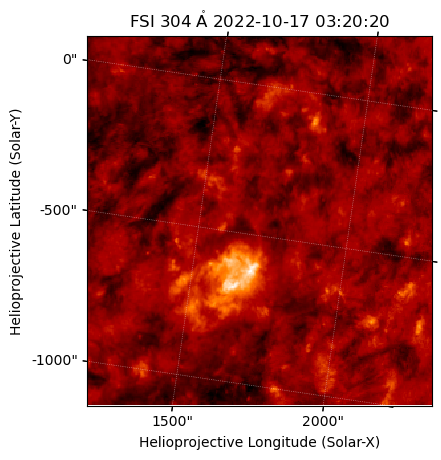

In [3]:
fsi_304_map_crop = fsi_304_map.submap(SkyCoord(1200*u.arcsec,-1000*u.arcsec, frame=fsi_304_map.coordinate_frame),
                                      top_right=SkyCoord(2200*u.arcsec,100*u.arcsec, frame=fsi_304_map.coordinate_frame))
fsi_304_map_crop.plot()

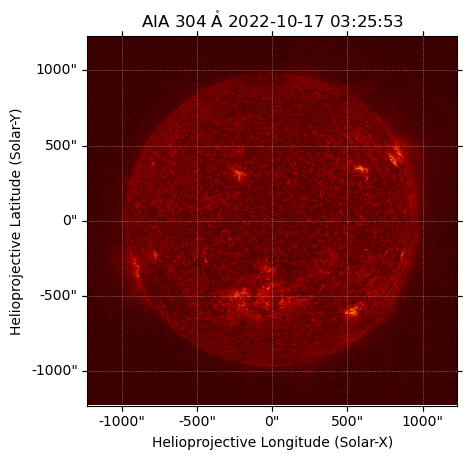

In [4]:
aia_304_map = sunpy.map.Map('../../../../src/AIA/20221017/304/lvl15/aia.lev1_euv_12s.2022-10-17T032551Z.304.image.fits')
aia_304_map.plot()

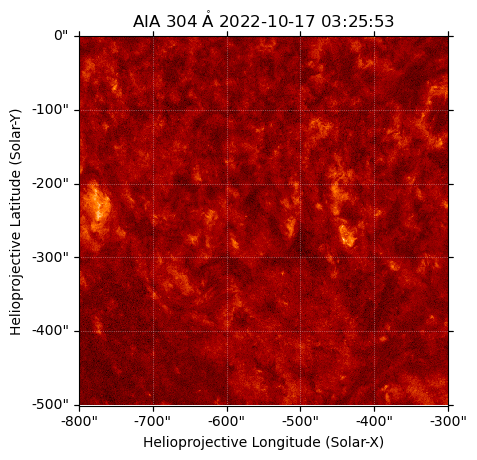

In [5]:
aia_304_map_crop = aia_304_map.submap(SkyCoord(-800*u.arcsec,-500*u.arcsec, frame=aia_304_map.coordinate_frame),
                                      top_right=SkyCoord(-300*u.arcsec,0*u.arcsec, frame=aia_304_map.coordinate_frame))
aia_304_map_crop.plot()

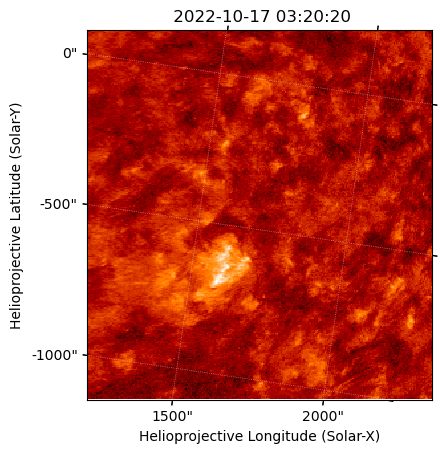

In [6]:
aia_304_repro = aia_304_map.reproject_to(fsi_304_map_crop.wcs)
aia_304_repro.plot()

In [7]:
SunBlinker(fsi_304_map_crop, aia_304_repro, fps=1)

In [8]:
fsi_304_map_crop_sub = fsi_304_map_crop.submap([20,20]*u.pix, top_right=[240, 240]*u.pix)

In [9]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

In [10]:
Txshift_fsi, Tyshift_fsi = coalign_shift(aia_304_repro, fsi_304_map_crop_sub)
Txshift_fsi, Tyshift_fsi

(<Angle -36.97623884 arcsec>, <Angle -4.19258784 arcsec>)

In [11]:
fsi_304_map_crop_sub_shift = fsi_304_map_crop_sub.shift_reference_coord(Txshift_fsi, Tyshift_fsi)

In [12]:
SunBlinker(fsi_304_map_crop_sub_shift, aia_304_repro, reproject=True,fps=1)

In [13]:
spice_coalign_filename = '../../../../src/SPICE/20221016/solo_L2_spice-n-ras_20221017T031211_V03_150995346-000_coalign.fits'
spice_coalign_cube = read_spice_l2_fits(spice_coalign_filename)
spice_coalign_cube.keys()

Set MJD-OBS to 59869.133468 from DATE-OBS.
Set MJD-BEG to 59869.133468 from DATE-BEG.
Set MJD-AVG to 59869.211569 from DATE-AVG.
Set MJD-END to 59869.289669 from DATE-END'. [astropy.wcs.wcs]


dict_keys(['O III 703 / Mg IX 706 (Merged)', 'S IV 750 - Peak', 'Ne VIII 770 / Mg VIII 772 (Merged)', 'Ne VIII 780 / Mg VIII 782 - SH', 'S V 786 / O IV 787 (Merged)'])

In [14]:
with fits.open(spice_coalign_filename) as hdul:
    spice_solarx_shift = hdul[-2].data.copy()
    spice_solary_shift = hdul[-1].data.copy()

In [15]:
spice_time = spice_coalign_cube['Ne VIII 770 / Mg VIII 772 (Merged)'].time[0]

In [16]:
with fits.open(spice_coalign_filename) as hdul:
    hdul.info()
    spice_coalign_header = hdul[2].header.copy()

Filename: ../../../../src/SPICE/20221016/solo_L2_spice-n-ras_20221017T031211_V03_150995346-000_coalign.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  O III 703 / Mg IX 706 (Merged)    1 PrimaryHDU     411   (224, 784, 80, 1)   float32   
  1  S IV 750 - Peak    1 ImageHDU       406   (224, 784, 50, 1)   float32   
  2  Ne VIII 770 / Mg VIII 772 (Merged)    1 ImageHDU       412   (224, 784, 72, 1)   float32   
  3  Ne VIII 780 / Mg VIII 782 - SH    1 ImageHDU       412   (224, 784, 80, 1)   float32   
  4  S V 786 / O IV 787 (Merged)    1 ImageHDU       412   (224, 784, 56, 1)   float32   
  5  VARIABLE_KEYWORDS    1 BinTableHDU    372   1R x 26C   [224D, 224I, 224I, 224I, 224I, 224I, 224E, 224E, 224E, 224E, 7I, 7I, 7I, 7I, 7J, 7J, 7J, 7J, 5152A, 224D, 224D, 80D, 50D, 72D, 80D, 56D]   
  6  WCSDVARR      1 ImageHDU        37   (224,)   float64   
  7  WCSDVARR      2 ImageHDU        37   (224,)   float64   


In [17]:
spice_coalign_header['CRVAL1'] = spice_coalign_header['CRVAL1'] + Txshift_fsi.to_value(u.arcsec)
spice_coalign_header['CRVAL2'] = spice_coalign_header['CRVAL2'] + Tyshift_fsi.to_value(u.arcsec)

In [18]:
spice_coalign_wcs = WCS(spice_coalign_header).dropaxis(2)[:,120:660,:]

In [19]:
saffron_dir = '../../../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221017T031211_V03_150995346-000/con-06/'

In [20]:
def interpolate_spice_map_to_target_wcs(spice_map, spice_coalign_wcs, spice_time,
                                        target_wcs,
                                        spice_solarx_shift=spice_solarx_shift, 
                                        spice_solary_shift=spice_solary_shift):
    spice_nx = spice_nt = spice_map.data.shape[1]
    spice_map = spice_map.submap([0, 120]*u.pix, top_right=[spice_nx, 659]*u.pix)
    spice_ny = spice_map.data.shape[0]
    spice_pix_t, spice_pix_y, spice_pix_x = np.indices((1,*spice_map.data.shape))
    spice_world_coords = spice_coalign_wcs.pixel_to_world(spice_pix_x, spice_pix_y, spice_pix_t)[0][0,:,:]

    solar_orbiter_loc = np.flip(get_horizons_coord('solar orbiter',
                                                {'start':spice_time[-1],
                                                'stop':spice_time[0],
                                                'step':f'{spice_nt}'}))
    
    spice_pix_y_in_target_wcs = np.zeros((spice_ny, spice_nx))
    spice_pix_x_in_target_wcs = np.zeros((spice_ny, spice_nx))

    for ii in range(spice_nt):
        spice_world_coord_t = SkyCoord(spice_world_coords[:,ii].Tx.to(u.arcsec) + spice_solarx_shift[ii]*u.arcsec, 
                                  spice_world_coords[:,ii].Ty.to(u.arcsec) + spice_solary_shift[ii]*u.arcsec,
                                  frame='helioprojective',obstime=spice_time[ii], 
                                  observer=solar_orbiter_loc[ii], 
                                  rsun=(696.e6 + 2.8e6)*u.m,)
        
        with propagate_with_solar_surface(rotation_model='rigid'):
            spice_pix_x_in_target_wcs[:,ii], spice_pix_y_in_target_wcs[:,ii] = target_wcs.world_to_pixel(spice_world_coord_t)

    hri_map_pix_y, hri_map_pix_x = np.indices((spice_ny, spice_nx))

    spice_map_interpolator = LinearNDInterpolator((spice_pix_x_in_target_wcs.flatten(), spice_pix_y_in_target_wcs.flatten()), spice_map.data.flatten())

    spice_map_interpolated = spice_map_interpolator(hri_map_pix_x, hri_map_pix_y)

    spice_map_interpolated = sunpy.map.Map(spice_map_interpolated, target_wcs)
    spice_map_interpolated.meta['rsun_ref'] = 696.e6 + 2.8e6

    return spice_map_interpolated

In [21]:
def get_saffron_map(saffron_dir, saffron_filename, spice_coalign_wcs, spice_time, target_wcs, velmap=False):
    saffron_files = glob(os.path.join(saffron_dir, saffron_filename))

    saffron_intmaps = []
    if velmap:
        saffron_velmaps = []

    for saffron_file in saffron_files:
        saffron_map = sunpy.map.Map(saffron_file)
        saffron_intmap = saffron_map[0]
        saffron_widmap = saffron_map[2]
        saffron_intmap = sunpy.map.Map(saffron_intmap.data*saffron_widmap.data*np.sqrt(np.pi), saffron_intmap.meta)
        saffron_intmap = interpolate_spice_map_to_target_wcs(saffron_intmap, spice_coalign_wcs, spice_time, target_wcs)

        saffron_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(saffron_intmap.data, 0.5),
                                                                vmax=np.nanpercentile(saffron_intmap.data, 99.5),
                                                                stretch=AsinhStretch())
        saffron_intmaps.append(saffron_intmap)


        if velmap:
            saffron_velmap = saffron_map[1]

            saffron_velmap_data = saffron_velmap.data.copy()
            saffron_velmap_data = (saffron_velmap_data/np.nanmedian(saffron_velmap_data) - 1)*const.c.to_value(u.km/u.s)
            saffron_velmap_median = np.nanmedian(saffron_velmap_data[120:660,:], axis=0)
            saffron_velmap_median_fit_param = np.polyfit(np.arange(saffron_velmap_median.shape[0]), saffron_velmap_median, 1)
            saffron_velmap_data = saffron_velmap_data - np.polyval(saffron_velmap_median_fit_param, np.arange(saffron_velmap_median.shape[0]))[np.newaxis,:]
            saffron_velmap = sunpy.map.Map(saffron_velmap_data, saffron_map[1].meta)

            saffron_velmap = interpolate_spice_map_to_target_wcs(saffron_velmap, spice_coalign_wcs, spice_time, target_wcs)
            saffron_velmap.plot_settings['norm'] = ImageNormalize(vmin=-40, vmax=40)
            saffron_velmaps.append(saffron_velmap)

    if velmap:
        if len(saffron_files) == 1:
            return saffron_intmaps[0], saffron_velmaps[0]
        else:
            return saffron_intmaps, saffron_velmaps
    else:
        if len(saffron_files) == 1:
            return saffron_intmaps[0]
        else:
            return saffron_intmaps

In [28]:
spice_coalign_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'UTC' 
CRVAL : -0.5574211785855694 0.2374303442191969 6747.875 
CRPIX : 112.5 272.5 1.0 
PC1_1 PC1_2 PC1_3  : 0.990629392512 -0.036398560098058 0.0 
PC2_1 PC2_2 PC2_3  : 0.51247650018437 0.990629392512 0.0 
PC3_1 PC3_2 PC3_3  : -60.25 0.0 1.0 
CDELT : 0.0011444444444444445 0.00030500000000000004 1.0 
NAXIS : 224  540  1

In [37]:
spice_target_header = deepcopy(spice_coalign_header)
spice_target_header['NAXIS'] = 2
spice_target_header.pop('NAXIS3', None)
spice_target_header.pop('CTYPE3', None)
spice_target_header.pop('CRPIX3', None)
spice_target_header.pop('CRVAL3', None)
spice_target_header.pop('CDELT3', None)
spice_target_header.pop('CUNIT3', None)
spice_target_header.pop('PC3_1', None)
spice_target_header.pop('PC3_2', None)
spice_target_header.pop('PC3_3', None)
spice_target_header.pop('PC1_3', None)
spice_target_header.pop('PC2_3', None)
spice_target_header.pop('PC3_3', None)
spice_target_header.pop('CROTA3', None)
spice_target_header.pop('CNAME3', None)
spice_target_header.pop('NAXIS4', None)
spice_target_header.pop('CTYPE4', None)
spice_target_header.pop('CRPIX4', None)
spice_target_header.pop('CRVAL4', None)
spice_target_header.pop('CDELT4', None)
spice_target_header.pop('CUNIT4', None)
spice_target_header.pop('PC4_1', None)
spice_target_header.pop('PC4_2', None)
spice_target_header.pop('PC4_3', None)
spice_target_header.pop('PC4_4', None)
spice_target_header.pop('PC1_4', None)
spice_target_header.pop('PC2_4', None)
spice_target_header.pop('PC3_4', None)
spice_target_header.pop('PC4_4', None)
spice_target_header.pop('CROTA4', None)
spice_target_header.pop('CNAME4', None)
spice_target_wcs = WCS(spice_target_header)[120:660,:]

Set MJD-OBS to 59869.133468 from DATE-OBS.
Set MJD-BEG to 59869.133468 from DATE-BEG.
Set MJD-AVG to 59869.211569 from DATE-AVG.
Set MJD-END to 59869.289669 from DATE-END'. [astropy.wcs.wcs]


In [38]:
spice_target_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : -0.5574211785855694 0.2374303442191969 
CRPIX : 112.5 272.5 
PC1_1 PC1_2  : 0.990629392512 -0.036398560098058 
PC2_1 PC2_2  : 0.51247650018437 0.990629392512 
CDELT : 0.0011444444444444445 0.00030500000000000004 
NAXIS : 224  540

In [39]:
saffron_NeVIII_intmap, saffron_NeVIII_velmap = get_saffron_map(saffron_dir, '*770.42-ne_8*.fits',
                                                                spice_coalign_wcs, spice_time, spice_target_wcs, velmap=True)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [40]:
eis_195_velmap_derot = sunpy.map.Map('../../../../src/EIS/DHB_007_v2/20221020T2343/sunpymaps/eis_195_velmap_shift.fits')
eis_195_velmap_derot.meta['rsun_ref'] = 696000000 + 2.8e6
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_195_velmap_derot_repro_hrifov = eis_195_velmap_derot.reproject_to(saffron_NeVIII_velmap.wcs)

For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,dsun_obs,crlt_obs
 [sunpy.map.mapbase]


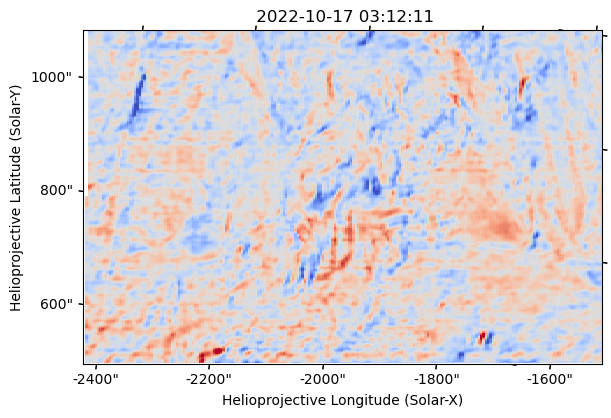

In [41]:
fig = plt.figure(figsize=(6,5),layout='constrained')
ax = fig.add_subplot(111, projection=saffron_NeVIII_velmap)
saffron_NeVIII_velmap.plot(axes=ax, aspect=saffron_NeVIII_velmap.scale.axis2/saffron_NeVIII_velmap.scale.axis1,
                           norm=ImageNormalize(vmin=-40, vmax=40), cmap='coolwarm')

(-0.5, 223.5, -0.5, 539.5)

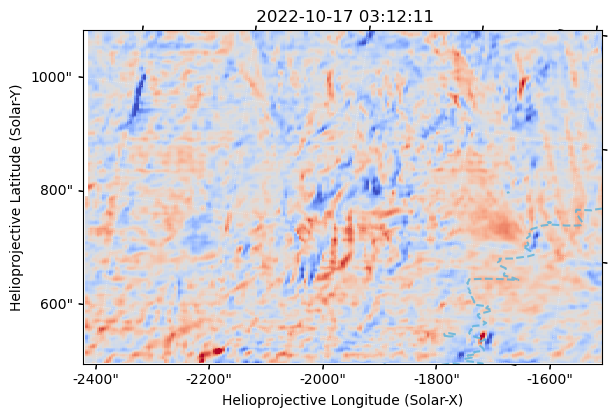

In [43]:
fig = plt.figure(figsize=(6,5),layout='constrained')
ax = fig.add_subplot(111, projection=saffron_NeVIII_velmap)
saffron_NeVIII_velmap.plot(axes=ax, aspect=saffron_NeVIII_velmap.scale.axis2/saffron_NeVIII_velmap.scale.axis1,
                           norm=ImageNormalize(vmin=-40, vmax=40), cmap='coolwarm')
ax_bounds = ax.axis()
with propagate_with_solar_surface(rotation_model='rigid'):
    eis_195_velmap_derot.draw_contours(levels=[-5],colors=["#58B2DC"],alpha=0.8,
                                                                   axes=ax)
ax.axis(ax_bounds)

In [44]:
saffron_NeVIII_intmap.save('../../../../src/coalign_map/20221017/spice_NeVIII_intmap_derot.fits', overwrite=True)
saffron_NeVIII_velmap.save('../../../../src/coalign_map/20221017/spice_NeVIII_velmap_derot.fits', overwrite=True)